# **Unsupervised Domain Adaptation Through CycleGAN**

The objective of this work is to propose an approach to address the problem of domain adaptation through the use of generative adversarial networks. Specifically, it will be evaluated the effectiveness of CycleGAN in performing the image translation from the source to the target domain, and how much this operation can impact on the final image classification task in terms of accuracy. 

CycleGAN is a GAN-based model which allows to perform unpaired image-to-image translation. It combines two GANs in a cyclical manner: the first generator allows to pass from the domain A to the domain B, then the second generator allows to come back from B to A.

The idea is to train a CycleGAN to translate images among source and target domains, extract the generator which allows to pass from source to target and use it either chained with the final CNN to produce “target-like” images on-the-fly as the training proceeds, or autonomously to generate offline a new version of the dataset which will be used to train the final CNN.


Import main libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle as pkl
import h5py

## Utility Functions

Define some utility functions

In [2]:
class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']


# utility function to plot some figures
def plot_figures(x, n, lab=None, figsize=None):
  if figsize:
      plt.figure(figsize=figsize)
  for i in range(n*n):
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      # rescale for visualization purposes
      img = 0.5*x[i] + 0.5
      plt.imshow(img, cmap=plt.cm.gray)
      if lab is not None:
        plt.xlabel(class_names[lab[i]])
    
  plt.show()


# utility function to plot losses
def plot_losses(history):
  pd.DataFrame(history.history).plot(figsize=(10,6))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()


# utility function to plot confusion matrix
def plot_conf_matrix(conf_matrix):
  plt.figure(figsize=(8,8))

  axes = sns.heatmap(conf_matrix,
                    cmap='Oranges',
                    xticklabels=class_names, 
                    yticklabels=class_names,
                    fmt='.4g',
                    cbar=False,
                    annot=True, 
                    square=True)

  axes.set_xlabel('Predicted label')
  axes.set_ylabel('True label')
  axes.set_title("Confusion Matrix")
  plt.show()


# utility function to compute accuracy mean and standard deviation
def compute_accuracy_mean_std(x_train, y_train, x_val, y_val, x_test, y_test, l_rate=5e-03 , b_size=256 ,n=5):
  test_acc = list()

  for _ in range(n):
    adam = keras.optimizers.Adam(learning_rate=l_rate)

    model = cnn_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    
    callback_es = [tf.keras.callbacks.EarlyStopping(min_delta = 1e-04, patience=5), 
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0)]

    history = model.fit(x_train, 
                        y_train, 
                        epochs=30, 
                        batch_size = b_size, 
                        validation_data=(x_val, y_val),
                        callbacks=[callback_es])
    
    _, accuracy = model.evaluate(x_test, y_test)
    test_acc.append(accuracy)

  print('*'*40)
  print('Mean Accuracy: ', np.mean(test_acc))
  print('Standard Deviation: ', np.std(test_acc))


# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X-2, 0), np.max(X+2, 0)
    X = (X - x_min) / (x_max - x_min)
    
    plt.figure(figsize=(10,10))
    cmap = plt.cm.get_cmap('tab10')

    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=cmap(y[i]), fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title) 
    plt.show()


# Scale and visualize the embedding vectors
def plot_domains_embedding(X_A, y_A, X_B, y_B, title=None, lab1='Source Domain', lab2='Target Domain'):
  x_min, x_max = np.min(np.concatenate([X_A, X_B])-2, 0), np.max(np.concatenate([X_A, X_B])+2, 0)
  X_A = (X_A - x_min) / (x_max - x_min)
  X_B = (X_B - x_min) / (x_max - x_min)

  plt.figure(figsize=(10,10))

  cmap = plt.cm.get_cmap('tab10')

  for i in range(X_A.shape[0]):
    plt.text(X_A[i, 0], X_A[i, 1], str(y_A[i]),
             color=cmap(0), fontdict={'weight': 'bold', 'size': 9})

  for i in range(X_B.shape[0]):
    plt.text(X_B[i, 0], X_B[i, 1], str(y_B[i]),
             color=cmap(1), fontdict={'weight': 'bold', 'size': 9})
  
  plt.xticks([]), plt.yticks([])
  plt.annotate(lab1, xy=(0.77,0.95), fontsize=14, color=cmap(0), backgroundcolor="w")
  plt.annotate(lab2, xy=(0.77,0.92), fontsize=14, color=cmap(1), backgroundcolor="w")
  if title is not None:
      plt.title(title)
  plt.show()


def plot_gen_vs_real(origin_imgs, gen_imgs, real_imgs, indicies, n_imgs=8):
  #plt.figure(figsize=(16,4))
  plt.figure(figsize=(16,6))  
  plt.suptitle('Generated Images vs Nearest Real Images')
  
  for i in range(n_imgs):
    plt.subplot(3,n_imgs,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = origin_imgs[i]
    # rescale for visualization purposes
    img = 0.5*img + 0.5
    plt.imshow(img.reshape(32,32,3), cmap=plt.cm.gray)

    plt.subplot(3,n_imgs,i+1+n_imgs)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = gen_imgs[i]
    # rescale for visualization purposes
    img = 0.5*img + 0.5
    plt.imshow(img.reshape(32,32,3), cmap=plt.cm.gray)

    plt.subplot(3,n_imgs,i+1+2*n_imgs)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = real_imgs[indices[i]]
    # rescale for visualization purposes
    img = 0.5*img + 0.5
    plt.imshow(img.reshape(32,32,3), cmap=plt.cm.gray)

  plt.show()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

directory_models="/content/drive/MyDrive/Keras/models/"


Mounted at /content/drive


## Dataset

Choose and load a couple of Dataset as Domain A and Domain B (e.g. MNIST and MNIST-M)

### *Load MNIST Dataset (Domain A)*

Load and Prepare Dataset 

In [4]:
(x_train_A, y_train_A), (x_test_A, y_test_A) = keras.datasets.mnist.load_data()

# Normalize images (scale in range [-1, 1])
x_train_A = x_train_A.astype(np.float32) / 127.5 - 1
x_test_A = x_test_A.astype(np.float32) / 127.5 - 1

x_train_A= x_train_A.reshape(x_train_A.shape[0], x_train_A.shape[1], x_train_A.shape[2], 1)
x_test_A = x_test_A.reshape(x_test_A.shape[0], x_test_A.shape[1], x_test_A.shape[2], 1)

# Resize images (32x32)
x_train_A = np.array([tf.image.resize(x, (32, 32)) for x in tqdm(x_train_A)])
x_test_A = np.array([tf.image.resize(x, (32, 32)) for x in tqdm(x_test_A)])

x_train_A= x_train_A.reshape(x_train_A.shape[0], x_train_A.shape[1], x_train_A.shape[2])
x_test_A = x_test_A.reshape(x_test_A.shape[0], x_test_A.shape[1], x_test_A.shape[2])

# Convert images to RGB
x_train_A = np.expand_dims(x_train_A, axis=-1)
x_train_A = np.repeat(x_train_A, 3, axis=-1)
x_test_A = np.expand_dims(x_test_A, axis=-1)
x_test_A = np.repeat(x_test_A, 3, axis=-1)

# Reserve samples for validation
x_train_A, x_val_A, y_train_A, y_val_A = train_test_split(x_train_A, y_train_A, 
                                                          test_size=10000, 
                                                          random_state=42)

print("Training Set shape:", x_train_A.shape)
print("Validation Set shape:", x_val_A.shape)
print("Test Set shape:", x_test_A.shape)


11493376/11490434 [==============================] - 0s 0us/step


100%|██████████| 10000/10000 [00:05<00:00, 1673.39it/s]


Training Set shape: (50000, 32, 32, 3)
Validation Set shape: (10000, 32, 32, 3)
Test Set shape: (10000, 32, 32, 3)


Show some samples

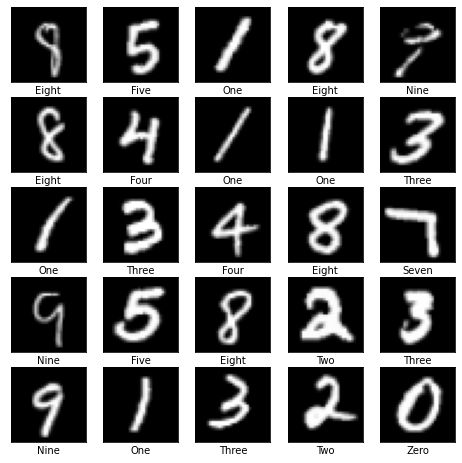

In [5]:
plot_figures(x_train_A, n=5, lab=y_train_A, figsize=(8,8))

### *Load USPS Dataset (Domain B)*

Load and Prepare Dataset 

In [ ]:
# Get the dataset
if not os.path.exists('./usps.h5'):
  !wget 'https://www.dropbox.com/s/0of1r2fp63441r8/usps.h5?dl=0' -O usps.h5

# Extract train and test sets
with h5py.File('usps.h5', 'r') as hf:
  train = hf.get('train')
  x_train_B = train.get('data')[:]
  y_train_B = train.get('target')[:]
  test = hf.get('test')
  x_test_B = test.get('data')[:]
  y_test_B = test.get('target')[:]

# Normalize images (scale in range [-1, 1])
x_train_B = (x_train_B.astype(np.float32) - 0.5) * 2
x_test_B = (x_test_B.astype(np.float32) - 0.5) * 2

x_train_B = x_train_B.reshape(x_train_B.shape[0], 16, 16, 1)
x_test_B = x_test_B.reshape(x_test_B.shape[0], 16, 16, 1)

# Resize images (32x32)
x_train_B = np.array([tf.image.resize(x, (32, 32)) for x in tqdm(x_train_B)])
x_test_B = np.array([tf.image.resize(x, (32, 32)) for x in tqdm(x_test_B)])

x_train_B= x_train_B.reshape(x_train_B.shape[0], x_train_B.shape[1], x_train_B.shape[2])
x_test_B = x_test_B.reshape(x_test_B.shape[0], x_test_B.shape[1], x_test_B.shape[2])

# Convert images to RGB
x_train_B = np.expand_dims(x_train_B, axis=-1)
x_train_B = np.repeat(x_train_B, 3, axis=-1)
x_test_B = np.expand_dims(x_test_B, axis=-1)
x_test_B = np.repeat(x_test_B, 3, axis=-1)

# Reserve samples for validation
x_train_B, x_val_B, y_train_B, y_val_B = train_test_split(x_train_B, y_train_B, 
                                                          test_size=0.1, 
                                                          random_state=42)

print("Training Set shape:", x_train_B.shape)
print("Validation Set shape:", x_val_B.shape)
print("Test Set shape:", x_test_B.shape)


--2021-08-01 16:19:20--  https://www.dropbox.com/s/0of1r2fp63441r8/usps.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0of1r2fp63441r8/usps.h5 [following]
--2021-08-01 16:19:20--  https://www.dropbox.com/s/raw/0of1r2fp63441r8/usps.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3eaafa4da4f36d1a13768eeb79.dl.dropboxusercontent.com/cd/0/inline/BTafv5rmg1JaLvfqy74rOYHL1KVetiERemONRNumowOOs2mDkrt2x1N8Y4qtChqUknFBmR9oOJBu90JNo8eQoLYRTjzW6_0uGNDLmJv0Lbd9Ku9LX7sUPSopyOLe6pEohdK0JNScUZO2s5cwR46r4Kfd/file# [following]
--2021-08-01 16:19:21--  https://uc3eaafa4da4f36d1a13768eeb79.dl.dropboxusercontent.com/cd/0/inline/BTafv5rmg1JaLvfqy74rOYHL1KVetiERemONRNumowOOs2mDkrt2x1N8Y4qtChqUknFBmR9oOJBu90JNo8eQoLYRTjzW6_0uGNDL

100%|██████████| 2007/2007 [00:00<00:00, 2428.17it/s]


Training Set shape: (6561, 32, 32, 3)
Validation Set shape: (730, 32, 32, 3)
Test Set shape: (2007, 32, 32, 3)


Show some samples

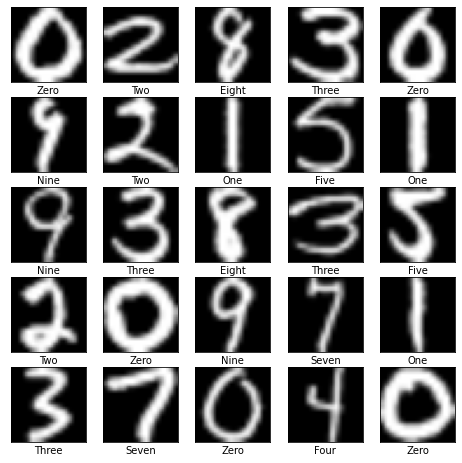

In [ ]:
plot_figures(x_train_B, n=5, lab=y_train_B, figsize=(8,8))

### *Load MNIST-M Dataset (Domain B)*

Load and Prepare Dataset 

In [6]:
if not os.path.exists('./keras_mnistm.pkl'):
  !wget 'https://www.dropbox.com/s/vodamzy05xnvmj8/keras_mnistm.pkl?dl=0' -O keras_mnistm.pkl

mnistm = pkl.load(open('keras_mnistm.pkl', 'rb'), encoding="bytes")

x_train_B, x_test_B = mnistm[b'train'], mnistm[b'test']
(_, y_train_B), (_, y_test_B) = keras.datasets.mnist.load_data()

# Normalize images (scale in range [-1, 1])
x_train_B = x_train_B.astype(np.float32) / 127.5 - 1
x_test_B = x_test_B.astype(np.float32) / 127.5 - 1

# Resize images (32x32)
x_train_B = np.array([tf.image.resize(x, (32, 32)) for x in tqdm(x_train_B)])
x_test_B = np.array([tf.image.resize(x, (32, 32)) for x in tqdm(x_test_B)])

# Reserve samples for validation
x_train_B, x_val_B, y_train_B, y_val_B = train_test_split(x_train_B, y_train_B, 
                                                          test_size=10000, 
                                                          random_state=42)

print("Training Set shape:", x_train_B.shape)
print("Validation Set shape:", x_val_B.shape)
print("Test Set shape:", x_test_B.shape)


--2021-08-04 08:28:50--  https://www.dropbox.com/s/vodamzy05xnvmj8/keras_mnistm.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vodamzy05xnvmj8/keras_mnistm.pkl [following]
--2021-08-04 08:28:50--  https://www.dropbox.com/s/raw/vodamzy05xnvmj8/keras_mnistm.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7369f25fb3ca5d14630ab7200a.dl.dropboxusercontent.com/cd/0/inline/BTkrmVNGMmW246td3uk08GBKb1-nYyalywXV7qvubkVxdrETtnccpG6upXbkhponK1OX_5AO90wC0r8kNxtN__ZpUfRhOMM_KHd0XO-Fn6ZfUZb3cXhgNMG4VU3seCdwcb-mcazs-eFoCRz6JUGrjXcF/file# [following]
--2021-08-04 08:28:51--  https://uc7369f25fb3ca5d14630ab7200a.dl.dropboxusercontent.com/cd/0/inline/BTkrmVNGMmW246td3uk08GBKb1-nYyalywXV7qvubkVxdrETtnccpG6upXbkhponK1OX_5

100%|██████████| 10000/10000 [00:06<00:00, 1665.88it/s]


Training Set shape: (50000, 32, 32, 3)
Validation Set shape: (10000, 32, 32, 3)
Test Set shape: (10000, 32, 32, 3)


Show some samples

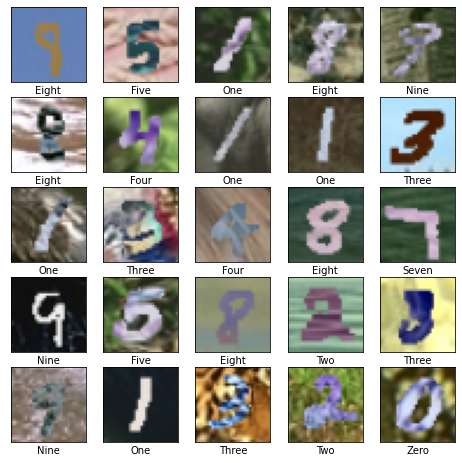

In [7]:
plot_figures(x_train_B, n=5, lab=y_train_B, figsize=(8,8))

### *Load SVHN Dataset (Domain B)*

Load and Prepare Dataset 

In [ ]:
x_train_B, y_train_B = tfds.as_numpy(tfds.load(
    'svhn_cropped',
    split='train',
    batch_size=-1,
    as_supervised=True,
))

x_test_B, y_test_B = tfds.as_numpy(tfds.load(
    'svhn_cropped',
    split='test',
    batch_size=-1,
    as_supervised=True,
))


# Normalize images (scale in range [-1, 1])
x_train_B = x_train_B.astype(np.float32) / 127.5 - 1
x_test_B = x_test_B.astype(np.float32) / 127.5 - 1

# Resize images (32x32)
x_train_B = np.array([tf.image.resize(x, (32, 32)) for x in tqdm(x_train_B)])
x_test_B = np.array([tf.image.resize(x, (32, 32)) for x in tqdm(x_test_B)])

# Reserve samples for validation
x_train_B, x_val_B, y_train_B, y_val_B = train_test_split(x_train_B, y_train_B, 
                                                          test_size=10000, 
                                                          random_state=42)

print("Training Set shape:", x_train_B.shape)
print("Validation Set shape:", x_val_B.shape)
print("Test Set shape:", x_test_B.shape)


Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteU941U3/svhn_cropped-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteU941U3/svhn_cropped-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteU941U3/svhn_cropped-extra.tfrecord


Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.


100%|██████████| 26032/26032 [00:11<00:00, 2236.57it/s]


Training Set shape: (63257, 32, 32, 3)
Validation Set shape: (10000, 32, 32, 3)
Test Set shape: (26032, 32, 32, 3)


Show some samples

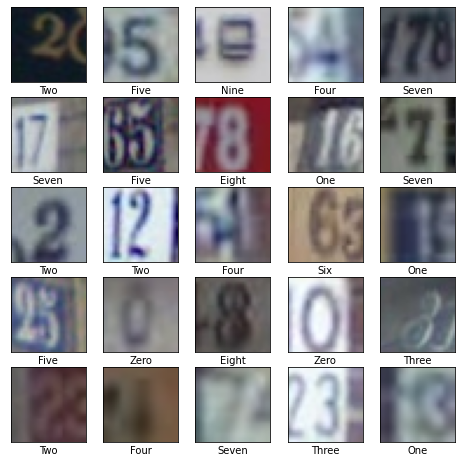

In [ ]:
plot_figures(x_train_B, n=5, lab=y_train_B, figsize=(8,8))

### *Compare Domains (t-SNE)*

*t-SNE plot (Domain A vs Domain B)*

Computing t-SNE embedding..


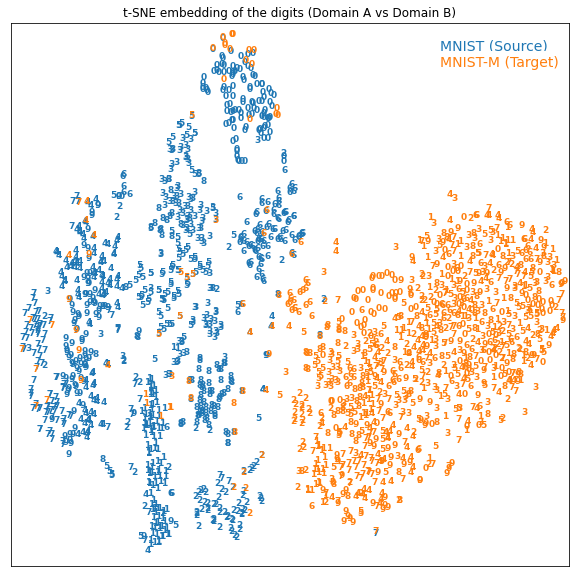

In [ ]:
print("Computing t-SNE embedding..")
tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(np.concatenate([x_train_A[:1000].reshape(1000, 3072),
                                            x_train_B[:1000].reshape(1000, 3072)]))

plot_domains_embedding(X_tsne[:1000], y_train_A[:1000],
                       X_tsne[1000:], y_train_B[:1000],
                       "t-SNE embedding of the digits (Domain A vs Domain B)",
                       lab1 = "MNIST (Source)",
                       lab2 = "MNIST-M (Target)")

## Classification

In this section will be defined the CNN used to classify images. It will be trained on Source (*Source only*) and evaluated on Target. Then, it will be trained on Target (*Target only*) and evaluated on Target. 

### *Define Model (CNN)*

In [9]:
def cnn_model():
  model = keras.models.Sequential([
        keras.layers.Conv2D(64, 5, activation="relu", 
                            input_shape=[32, 32, 3]),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(64, 5, activation="relu"), 
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(128, 5, activation="relu"), 
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
  ])

  return model


Define CNN and show details

In [ ]:
model = cnn_model()
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

### *Training (Source)*

Train CNN on Domain A

In [13]:
lr = 5e-03
#sgd = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(learning_rate=lr)

model = cnn_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [14]:
batch_size = 256

# define the callbacks for Early stopping, and reduce LR
callback_es = [tf.keras.callbacks.EarlyStopping(min_delta = 1e-04, patience=5), 
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0)]

history = model.fit(x_train_A, 
                    y_train_A, 
                    epochs=30, 
                    batch_size = batch_size, 
                    validation_data=(x_val_A, y_val_A),
                    callbacks=[callback_es])

Epoch 1/30
196/196 [==============================] - 5s 24ms/step - loss: 0.2370 - accuracy: 0.9245 - val_loss: 0.0637 - val_accuracy: 0.9810
Epoch 2/30
196/196 [==============================] - 4s 22ms/step - loss: 0.0540 - accuracy: 0.9831 - val_loss: 0.0675 - val_accuracy: 0.9800
Epoch 3/30
196/196 [==============================] - 4s 23ms/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 0.0544 - val_accuracy: 0.9862
Epoch 4/30
196/196 [==============================] - 4s 22ms/step - loss: 0.0380 - accuracy: 0.9886 - val_loss: 0.0521 - val_accuracy: 0.9866
Epoch 5/30
196/196 [==============================] - 4s 23ms/step - loss: 0.0310 - accuracy: 0.9904 - val_loss: 0.0500 - val_accuracy: 0.9885
Epoch 6/30
196/196 [==============================] - 4s 23ms/step - loss: 0.0311 - accuracy: 0.9905 - val_loss: 0.0487 - val_accuracy: 0.9876
Epoch 7/30
196/196 [==============================] - 4s 23ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.0531 - val_accuracy: 0.9843

Plot Accuracies and Losses

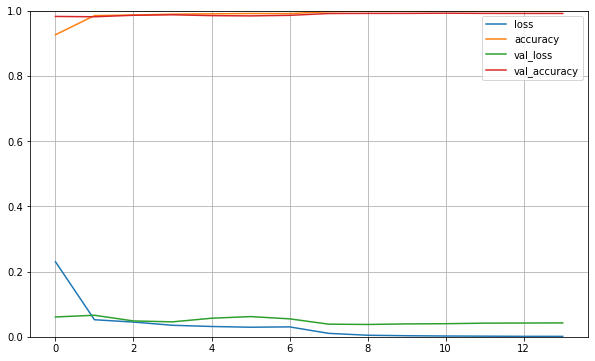

In [ ]:
del history.history['lr']
plot_losses(history)

### *Training (Target)*

Train CNN on Domain B

In [23]:
lr = 5e-03
#sgd = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(learning_rate=lr)

model = cnn_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [24]:
batch_size = 256

# define the callbacks for Early stopping, and reduce LR
callback_es = [tf.keras.callbacks.EarlyStopping(min_delta = 1e-04, patience=5), 
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0)]

history = model.fit(x_train_B, 
                    y_train_B, 
                    epochs=30, 
                    batch_size = batch_size, 
                    validation_data=(x_val_B, y_val_B),
                    callbacks=[callback_es])

Epoch 1/30
196/196 [==============================] - 5s 24ms/step - loss: 0.7321 - accuracy: 0.7666 - val_loss: 0.3007 - val_accuracy: 0.9082
Epoch 2/30
196/196 [==============================] - 4s 22ms/step - loss: 0.2587 - accuracy: 0.9215 - val_loss: 0.2297 - val_accuracy: 0.9306
Epoch 3/30
196/196 [==============================] - 4s 22ms/step - loss: 0.2036 - accuracy: 0.9383 - val_loss: 0.1809 - val_accuracy: 0.9467
Epoch 4/30
196/196 [==============================] - 4s 22ms/step - loss: 0.1803 - accuracy: 0.9455 - val_loss: 0.1771 - val_accuracy: 0.9477
Epoch 5/30
196/196 [==============================] - 4s 22ms/step - loss: 0.1526 - accuracy: 0.9539 - val_loss: 0.1621 - val_accuracy: 0.9507
Epoch 6/30
196/196 [==============================] - 4s 22ms/step - loss: 0.1428 - accuracy: 0.9558 - val_loss: 0.1816 - val_accuracy: 0.9442
Epoch 7/30
196/196 [==============================] - 4s 22ms/step - loss: 0.1399 - accuracy: 0.9576 - val_loss: 0.1557 - val_accuracy: 0.9544

Plot Accuracies and Losses

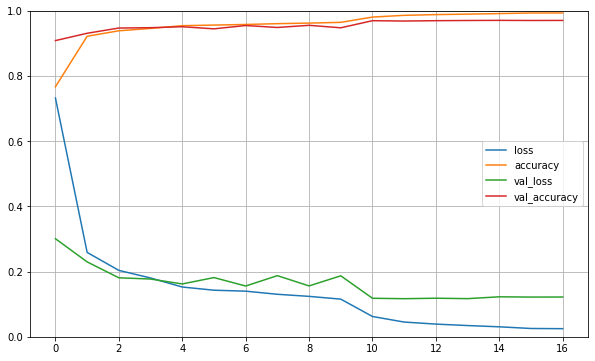

In [25]:
del history.history['lr']
plot_losses(history)

### *Test (Target only)*

Compute accuracy on Domain B while training only on Domain B

In [26]:
test_loss, test_acc = model.evaluate(x_test_B, y_test_B, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.1271 - accuracy: 0.9705

Test accuracy: 0.9704999923706055


In [ ]:
compute_accuracy_mean_std(x_train=x_train_B, 
                          y_train=y_train_B, 
                          x_val=x_val_B, 
                          y_val=y_val_B, 
                          x_test=x_test_B, 
                          y_test=y_test_B, n=1)

*Confusion Matrix*

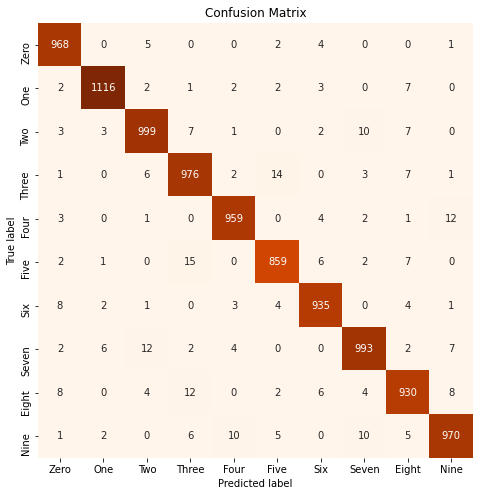

In [27]:
y_pred = np.argmax(model.predict(x_test_B), axis=-1)

conf_matrix = confusion_matrix(y_test_B, y_pred)

plot_conf_matrix(conf_matrix)

*Classification metrics*

In [28]:
print(classification_report(y_test_A, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Zero       0.97      0.99      0.98       980
         One       0.99      0.98      0.99      1135
         Two       0.97      0.97      0.97      1032
       Three       0.96      0.97      0.96      1010
        Four       0.98      0.98      0.98       982
        Five       0.97      0.96      0.97       892
         Six       0.97      0.98      0.97       958
       Seven       0.97      0.97      0.97      1028
       Eight       0.96      0.95      0.96       974
        Nine       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### *Test (Source only)*

Compute accuracy on Domain B while training only on Domain A

In [18]:
test_loss, test_acc = model.evaluate(x_test_B, y_test_B, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 1.4047 - accuracy: 0.5908

Test accuracy: 0.5907999873161316


In [ ]:
compute_accuracy_mean_std(x_train=x_train_A, 
                          y_train=y_train_A, 
                          x_val=x_val_A, 
                          y_val=y_val_A, 
                          x_test=x_test_B, 
                          y_test=y_test_B)

*Confusion Matrix*

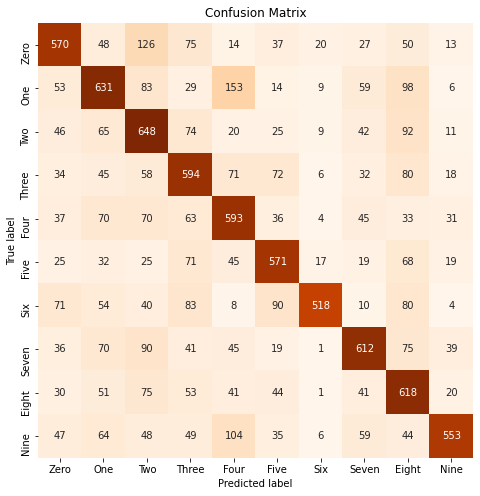

In [19]:
y_pred = np.argmax(model.predict(x_test_B), axis=-1)

conf_matrix = confusion_matrix(y_test_B, y_pred)

plot_conf_matrix(conf_matrix)

*Classification metrics*

In [17]:
print(classification_report(y_test_B, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Zero       0.60      0.58      0.59       980
         One       0.56      0.56      0.56      1135
         Two       0.51      0.63      0.56      1032
       Three       0.52      0.59      0.55      1010
        Four       0.54      0.60      0.57       982
        Five       0.61      0.64      0.62       892
         Six       0.88      0.54      0.67       958
       Seven       0.65      0.60      0.62      1028
       Eight       0.50      0.63      0.56       974
        Nine       0.77      0.55      0.64      1009

    accuracy                           0.59     10000
   macro avg       0.61      0.59      0.60     10000
weighted avg       0.61      0.59      0.59     10000



### *Features Visualization (t-SNE)*

*t-SNE plot extracted features (Domain A)*

Computing t-SNE embedding..


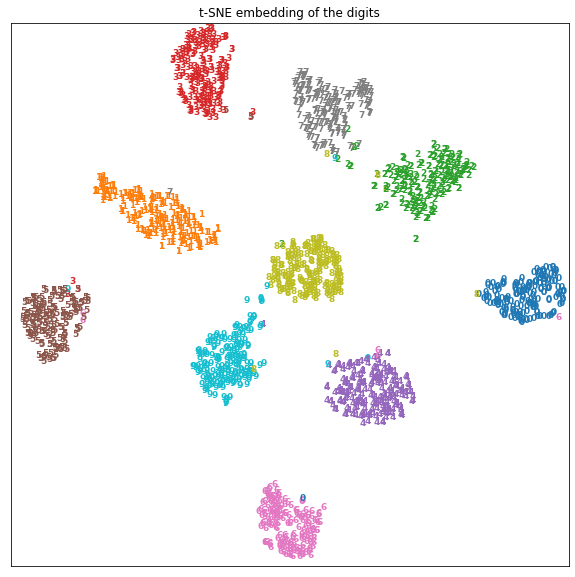

In [20]:
features_extractor = keras.models.Sequential(model.layers[:6])

embenddings = features_extractor.predict(x_test_A[:2000])

# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding..")
tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(embenddings)

plot_embedding(X_tsne, y_test_A, "t-SNE embedding of the digits")

*t-SNE plot extracted features (Domain B)*

Computing t-SNE embedding..


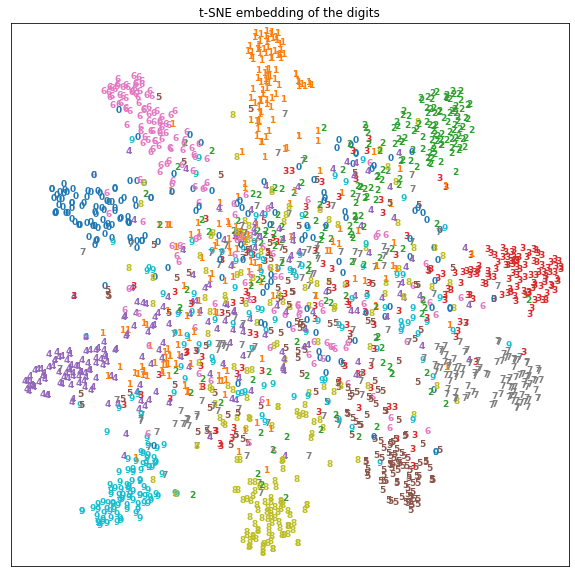

In [21]:
features_extractor = keras.models.Sequential(model.layers[:6])

embenddings = features_extractor.predict(x_test_B[:2000])

# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding..")
tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(embenddings)

plot_embedding(X_tsne, y_test_B, "t-SNE embedding of the digits")

*t-SNE plot extracted features (Domain A vs Domain B)*

Computing t-SNE embedding..


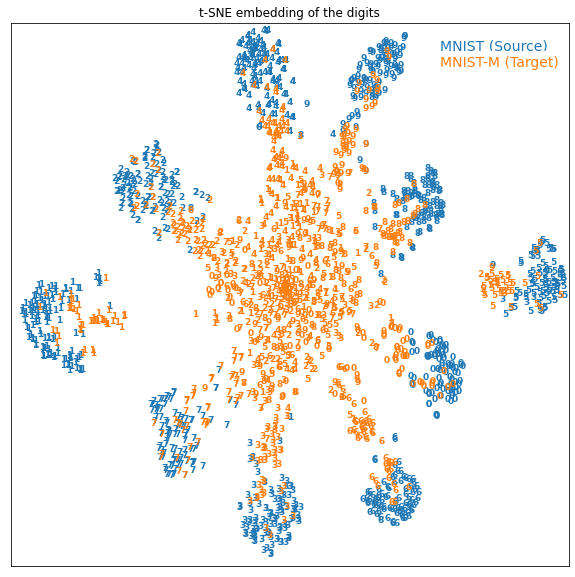

In [22]:
features_extractor = keras.models.Sequential(model.layers[:6])

embenddingsA = features_extractor.predict(x_test_A[:1000])
embenddingsB = features_extractor.predict(x_test_B[:1000])

embenddings = np.concatenate([embenddingsA, embenddingsB])

# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding..")
tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(embenddings)

plot_domains_embedding(X_tsne[:1000], y_test_A, 
                       X_tsne[1000:], y_test_B, 
                       "t-SNE embedding of the digits",
                       lab1 = "MNIST (Source)",
                       lab2 = "MNIST-M (Target)")

## Domain Adaptation

In [29]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

from tensorflow.keras.layers import Input, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense 
from tensorflow.keras.layers import BatchNormalization, Activation, ReLU, LeakyReLU
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model

import datetime

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-zexyyuyf
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-zexyyuyf
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=2fe7823a2518879a5ea356520a9981a0a522959d4a2432320e48f7970618eeea
  Stored in directory: /tmp/pip-ephem-wheel-cache-lzom7x47/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


### *Define Generator (U-Net)*

In [30]:
# Define the Encoder block
def conv2d(layer_input, filters, f_size=3, strides=2, instanceNorm=True):
  """Layers used during downsampling"""
  init = RandomNormal(stddev=0.02)
  d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same', kernel_initializer=init)(layer_input)
  if instanceNorm:
    d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  return d

# Define the Decoder block
def deconv2d(layer_input, skip_input, filters, f_size=3, strides=2, dropout_rate=0):
  """Layers used during upsampling"""
  init = RandomNormal(stddev=0.02)
  u = Conv2DTranspose(filters, kernel_size=f_size, strides=strides, padding='same', kernel_initializer=init)(layer_input)
  u = InstanceNormalization(axis=-1)(u)
  if dropout_rate:
    u = Dropout(dropout_rate)(u, training=True)
  u = Concatenate()([u, skip_input])
  u = ReLU()(u)
  return u


def unet_generator(img_shape=(32,32,3), channels=3, gf=32, name=None):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  
  # Image input
  input = Input(shape=img_shape)
  d0 = conv2d(input, gf, strides=1, instanceNorm=False)
  d0 = conv2d(d0, gf, strides=1, instanceNorm=False)


  # Downsampling #
  d1 = conv2d(d0, gf*2, instanceNorm=False)
  d1 = conv2d(d1, gf*2, strides=1)
  d1 = conv2d(d1, gf*2, strides=1)

  d2 = conv2d(d1, gf*4)
  d2 = conv2d(d2, gf*4, strides=1)
  d2 = conv2d(d2, gf*4, strides=1)

  
  # Bottleneck (4x4x256) #
  b = Conv2D(gf*8, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer=init)(d2)
  b = Conv2D(gf*8, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer=init)(b)
  b = Conv2D(gf*8, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer=init)(b)


  # Upsampling #
  u1 = deconv2d(b, d2, gf*4, dropout_rate=0.5)
  u1 = conv2d(u1, gf*4, strides=1)
  u1 = conv2d(u1, gf*4, strides=1)

  u2 = deconv2d(u1, d1, gf*2)
  u2 = conv2d(u2, gf*2, strides=1)
  u2 = conv2d(u2, gf*2, strides=1)


  output = deconv2d(u2, d0, gf)
  output = conv2d(output, gf, strides=1)
  output = conv2d(output, gf, strides=1)
  
  output = Conv2D(channels, kernel_size=3, strides=1, padding='same', activation='tanh', kernel_initializer=init)(output)

  return Model(input, output, name=name)


In [ ]:
unet_generator().summary()

In [ ]:
tf.keras.utils.plot_model(unet_generator(), "model.png", show_shapes=True)

### *Define Discriminator (PatchGAN)*

In [31]:
def d_layer(layer_input, filters, f_size=3, strides=2, normalization=True):
  """Discriminator layer"""
  init = RandomNormal(stddev=0.02)
  d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same', kernel_initializer=init)(layer_input)
  d = LeakyReLU(alpha=0.2)(d)
  if normalization:
    d = InstanceNormalization(axis=-1)(d)
  return d


def discriminator(img_shape=(32,32,3), df=64, name=None):
  init = RandomNormal(stddev=0.02)
  
  input = Input(shape=img_shape)

  d1 = d_layer(input, df, strides=2, normalization=False)
  d2 = d_layer(d1, df*2, strides=2)
  d3 = d_layer(d2, df*2, strides=1)
  
  output = Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid', kernel_initializer=init)(d3)
  
  return Model(input, output, name=name)


In [ ]:
discriminator().summary()

In [ ]:
tf.keras.utils.plot_model(discriminator(), "model.png", show_shapes=True)

*Compute Patch size*

In [ ]:
def receptive_field(output_size, kernel_size, stride_size):
  return kernel_size + (output_size - 1) * stride_size


# Last layer (1x1 output, 3x3 kernel, 1x1 stride)
rf = receptive_field(1, 3, 1)
# Third layer (3x3 output, 3x3 kernel, 1x1 stride)
rf = receptive_field(rf, 3, 1)
# Second layer (5x5 output, 3x3 kernel, 1x1 stride)
rf = receptive_field(rf, 3, 2)
# First layer (10x10 output, 3x3 kernel, 2x2 stride)
rf = receptive_field(rf, 3, 2)

# 1 pixel in the output refers to 23x23 patch on the original image
print('Patch size: ', rf, 'x', rf)

Patch size:  23 x 23


### *Define CycleGAN*

In [32]:
lambda_cycle = 8
lambda_id = 0.1 * lambda_cycle
img_shape = (32,32,3)
patch = int(img_shape[0] / 2**2)
disc_patch = (patch, patch, 1)

optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

# Create Discriminators
discriminator_A = discriminator(name='Discr_A')
discriminator_B = discriminator(name='Discr_B')

discriminator_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'], loss_weights=[0.5])
discriminator_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'], loss_weights=[0.5])

# Create Generators
gen_AB = unet_generator(name='Gen_AtoB')
gen_BA = unet_generator(name='Gen_BtoA')

# Input images from both domains
img_A = Input(img_shape, name='A')
img_B = Input(img_shape, name='B')

# Translate images to the other domain
fake_B = gen_AB(img_A)
fake_A = gen_BA(img_B)
# Translate images back to original domain
reconstr_A = gen_BA(fake_B)
reconstr_B = gen_AB(fake_A)
# Identity mapping of images
img_A_id = gen_BA(img_A)
img_B_id = gen_AB(img_B)

# For the combined model we will only train the generators
discriminator_A.trainable = False
discriminator_B.trainable = False

# Discriminators determines validity of translated images
valid_A = discriminator_A(fake_A)
valid_B = discriminator_B(fake_B)

# Combined model trains generators to fool discriminators
combined_model = Model(inputs=[img_A, img_B], 
                       outputs=[valid_B, valid_A,
                                reconstr_A, reconstr_B,
                                img_A_id, img_B_id])

combined_model.compile(loss=['mse', 'mse',
                             'mae', 'mae',
                             'mae', 'mae'],
                       loss_weights=[1, 1,
                                     lambda_cycle, lambda_cycle,
                                     lambda_id, lambda_id],
                       optimizer=optimizer)


In [ ]:
tf.keras.utils.plot_model(combined_model_AB, "model.png", show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(combined_model_BA, "model.png", show_shapes=True)

In [33]:
train_generator_A = keras.preprocessing.image.ImageDataGenerator()
train_generator_B = keras.preprocessing.image.ImageDataGenerator()

batch_size=32

train_A = train_generator_A.flow(x_train_A[:4096], y=y_train_A[:4096], shuffle=True, batch_size=batch_size)
train_B = train_generator_B.flow(x_train_B[:4096], y=y_train_B[:4096], shuffle=True, batch_size=batch_size)

### *Training*

In [ ]:
epochs = 50

# Adversarial loss ground truths
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

dA_real_losses, dA_fake_losses, dA_real_acc, dA_fake_acc = list(), list(), list(), list()
dB_real_losses, dB_fake_losses, dB_real_acc, dB_fake_acc = list(), list(), list(), list()
g_losses = list()

n_batches = int(len(x_train_A[:4096]) / batch_size)
sample_interval = int(n_batches / 2)

start_time = datetime.datetime.now()

for epoch in range(epochs):
  
  for step in range(n_batches):
    
    imgs_A, _ = next(train_A)
    imgs_B, _ = next(train_B)
    
    # Train Discriminators #  

    fake_B = gen_AB.predict(imgs_A)
    fake_A = gen_BA.predict(imgs_B)

    dA_loss_real = discriminator_A.train_on_batch(imgs_A, valid)
    dA_loss_fake = discriminator_A.train_on_batch(fake_A, fake)
    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

    dB_loss_real = discriminator_B.train_on_batch(imgs_B, valid)
    dB_loss_fake = discriminator_B.train_on_batch(fake_B, fake)
    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

    d_loss = 0.5 * np.add(dA_loss, dB_loss)

    # Train Generators #

    g_loss = combined_model.train_on_batch([imgs_A, imgs_B],
                                           [valid, valid,
                                            imgs_A, imgs_B,
                                            imgs_A, imgs_B])

    elapsed_time = datetime.datetime.now() - start_time

    # Log losses
    dA_real_losses.append(dA_loss_real[0] * 2)
    dA_fake_losses.append(dA_loss_fake[0] * 2)
    dB_real_losses.append(dB_loss_real[0] * 2)
    dB_fake_losses.append(dB_loss_fake[0] * 2)
    dA_real_acc.append(dA_loss_real[1])
    dA_fake_acc.append(dA_loss_fake[1])
    dB_real_acc.append(dB_loss_real[1])
    dB_fake_acc.append(dB_loss_fake[1])
    g_losses.append(g_loss[0] / 10.0)

    # Plot the progress
    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            step, n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:7]),
                                                                            elapsed_time))

    # Plot some generated images at sample interval
    if step % sample_interval == 0:
      imgs_A = x_train_A[:6]
      imgs_B = x_train_B[:6]

      fake_B = gen_AB.predict(imgs_A)
      fake_A = gen_BA.predict(imgs_B)

      reconstr_A = gen_BA.predict(fake_B)
      reconstr_B = gen_AB.predict(fake_A)

      print("\nRow 1: Domain A \n" +
              "Row 2: Domain B \n" +
              "Row 3: Fake A \n" +
              "Row 4: Fake B \n" +
              "Row 5: Reconstructed A \n" +
              "Row 6: Reconstructed B \n")

      gen_imgs = np.concatenate([imgs_A, imgs_B, fake_A, fake_B, reconstr_A, reconstr_B])
      
      plot_figures(gen_imgs, n=6, figsize=(8,8))
 
      # Save only generators 
      gen_AB.save(os.path.join(directory_models, "gen_AB/gen_AB_epoch_" + str(epoch) + "_step_" + str(step) + ".h5"));
      gen_BA.save(os.path.join(directory_models, "gen_BA/gen_BA_epoch_" + str(epoch) + "_step_" + str(step) + ".h5"));
    

*Plot losses and discriminators accuracies*

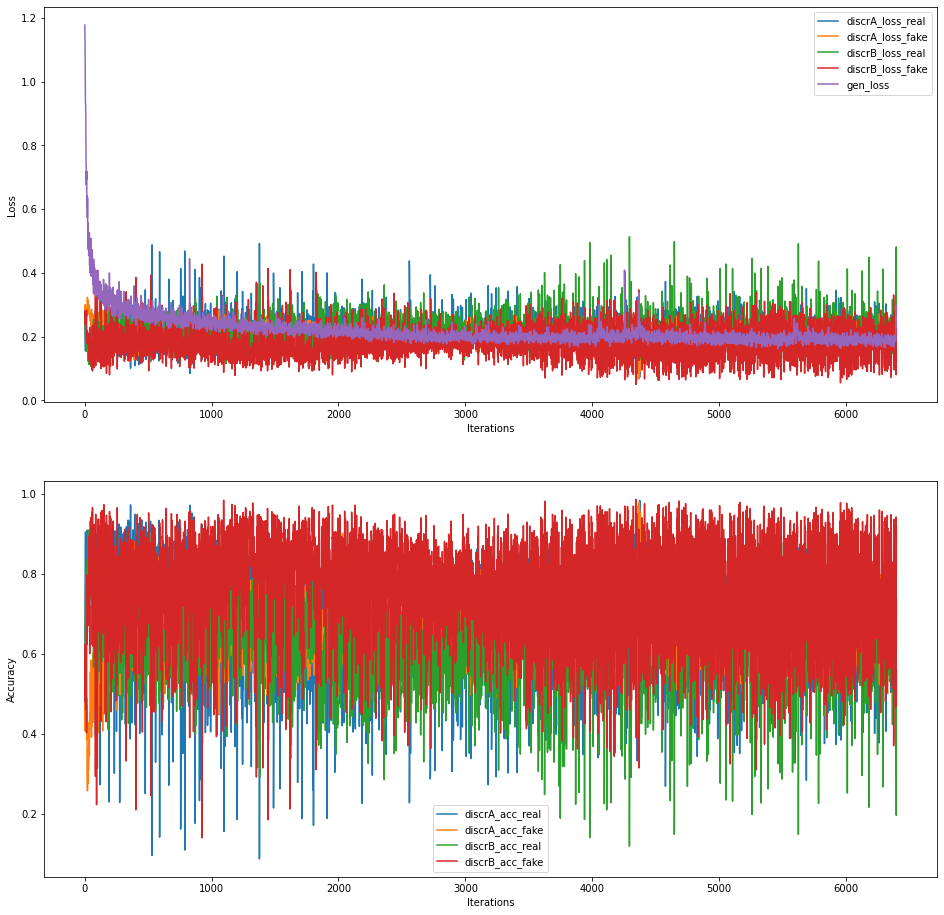

In [ ]:
plt.figure(figsize=(16,16))

# plot loss
plt.subplot(2, 1, 1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(dA_real_losses, label='discrA_loss_real')
plt.plot(dA_fake_losses, label='discrA_loss_fake')
plt.plot(dB_real_losses, label='discrB_loss_real')
plt.plot(dB_fake_losses, label='discrB_loss_fake')
plt.plot(g_losses, label='gen_loss')
plt.legend()

# plot discriminator accuracy
plt.subplot(2, 1, 2)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(dA_real_acc, label='discrA_acc_real')
plt.plot(dA_fake_acc, label='discrA_acc_fake')
plt.plot(dB_real_acc, label='discrB_acc_real')
plt.plot(dB_fake_acc, label='discrB_acc_fake')
plt.legend()

plt.show()

*Load the best generators*

In [35]:
# Choose epoch and step where the generator works better 
epoch = 46
step = 64

#leaky = tf.keras.layers.LeakyReLU(0.2)
instanceNorm = InstanceNormalization()
tf.keras.utils.get_custom_objects().update({#'LeakyReLU': leaky,
                                            'InstanceNormalization': instanceNorm})

#gen_AB = tf.keras.models.load_model(os.path.join(directory_models, "gen_AB/gen_AB_epoch_" + str(epoch) + "_step_" + str(step) + ".h5"))
#gen_BA = tf.keras.models.load_model(os.path.join(directory_models, "gen_BA/gen_BA_epoch_" + str(epoch) + "_step_" + str(step) + ".h5"))

gen_AB = tf.keras.models.load_model(os.path.join(directory_models, "best_models/mnist2mnist-m/gen_AB/gen_AB_epoch_" + str(epoch) + "_step_" + str(step) + ".h5"))
gen_BA = tf.keras.models.load_model(os.path.join(directory_models, "best_models/mnist2mnist-m/gen_BA/gen_BA_epoch_" + str(epoch) + "_step_" + str(step) + ".h5"))



### *Visualization*

*Plot some images generated with the best model*

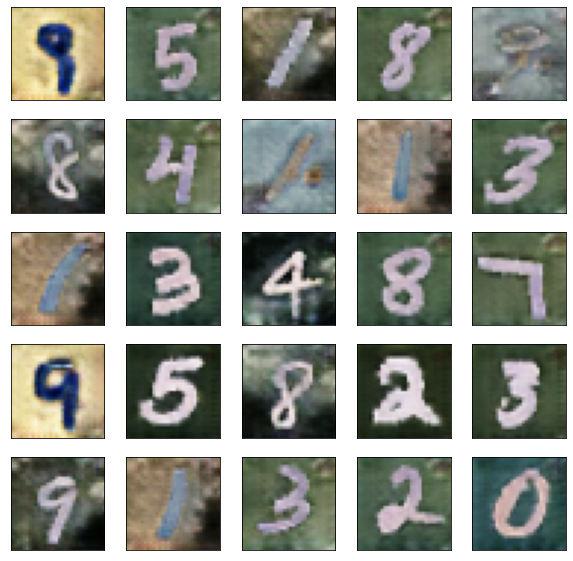

In [36]:
fake_B = gen_AB.predict(x_train_A[0:25])
plot_figures(fake_B, n=5, figsize=(10,10))

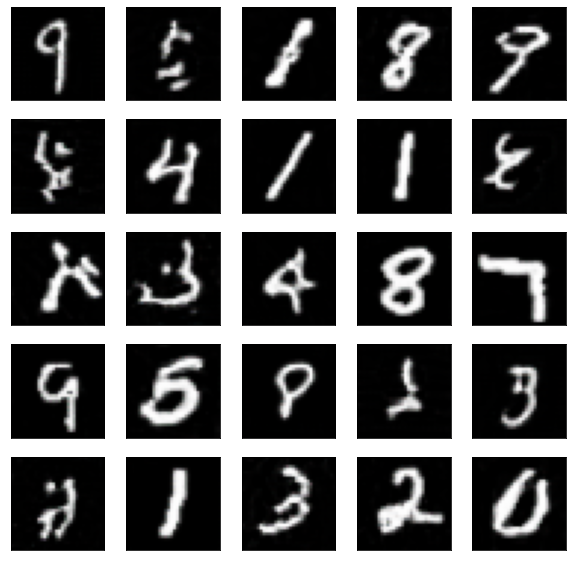

In [37]:
fake_A = gen_BA.predict(x_train_B[:25])
plot_figures(fake_A, n=5, figsize=(10,10))

*Plot some generated images and the nearest real images*

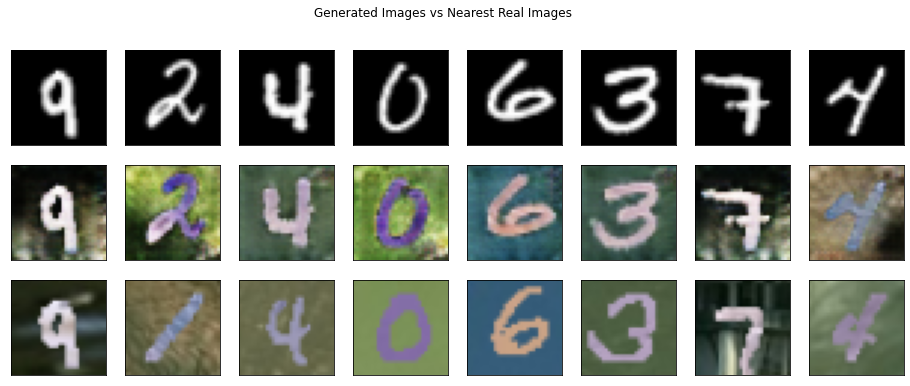

In [38]:
from sklearn.neighbors import NearestNeighbors


neighbors = NearestNeighbors(n_neighbors=1,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(x_train_B[:4500].reshape(4500, 3072))

gen_images = gen_AB.predict(x_train_A[4000:4008])
_, indices = neighbors.kneighbors(gen_images.reshape(gen_images.shape[0], 3072))


plot_gen_vs_real(x_train_A[4000:4008], gen_images, x_train_B, indices)


Plot some images generated from the same input to show the effect of Dropout at inference time.

In [ ]:
plt.figure(figsize=(16,2))

for i in range(8):
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if i is 0:
      img = x_train_A[0:1]
    else:
      img = gen_AB.predict(x_train_A[0:1])
    # rescale for visualization purposes
    img = 0.5*img[0] + 0.5
    plt.imshow(img, cmap=plt.cm.gray)
  
plt.show()

### *Compare Adapted Domains (t-SNE)*

In [39]:
x_train_fakeB = gen_AB.predict(x_train_A)
x_val_fakeB = gen_AB.predict(x_val_A)

*t-SNE plot (Domain A adapted vs Domain B)*

Computing t-SNE embedding..


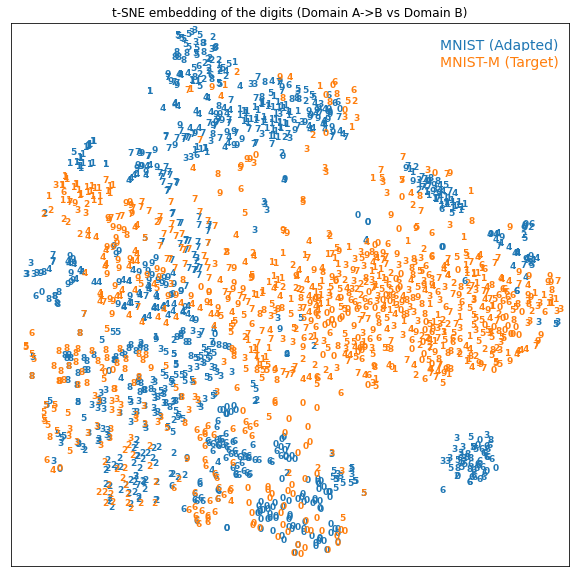

In [40]:
print("Computing t-SNE embedding..")
tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(np.concatenate([x_train_fakeB[:1000].reshape(1000, 3072),
                                            x_train_B[:1000].reshape(1000, 3072)]))

plot_domains_embedding(X_tsne[:1000], y_train_A[:1000],
                       X_tsne[1000:], y_train_B[:1000],
                       "t-SNE embedding of the digits (Domain A->B vs Domain B)",
                       lab1="MNIST (Adapted)",
                       lab2="MNIST-M (Target)")

## Classification after Adaptation

Two possibilities: 
- Chain the generator (freezed) and the CNN so that the generator 'translates' images from A to B on-the-fly during the training phase;
- Use the generator to 'translate' images from A to B, and train the CNN on the new Dataset generated.

The choice depends on how much disk space and computational power are available: 
- The first solution will not use more disk space, but it can slow down the traning phase;
- The latter will not affect the training phase lenght, but it requires much more disk space.

First solution: Chain Generator and CNN and then train the model

In [ ]:
'''
model = cnn_model()
gen_AB.trainable = False

img_A = Input(img_shape, name='A')
fake_B = gen_AB(img_A)
output = model(fake_B)

chained_model = Model(img_A, output)
chained_model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
'''

Second solution: Transform Dataset and then train CNN

In [41]:
x_train_fakeB = gen_AB.predict(x_train_A)
x_val_fakeB = gen_AB.predict(x_val_A)
x_test_fakeB = gen_AB.predict(x_test_A)

### *Training (Source->Target)*

In [45]:
lr = 5e-03
#sgd = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(learning_rate=lr)

model = cnn_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"])


In [46]:
batch_size = 256

# definisco la callback per Early stopping
callback_es = [tf.keras.callbacks.EarlyStopping(min_delta = 1e-04, patience=5), 
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0)]

history = model.fit(x_train_fakeB, 
                    y_train_A, 
                    epochs=30, 
                    batch_size = batch_size, 
                    validation_data=(x_val_fakeB, y_val_A),
                    callbacks=[callback_es])


Epoch 1/30
196/196 [==============================] - 5s 24ms/step - loss: 0.2972 - accuracy: 0.9087 - val_loss: 0.1189 - val_accuracy: 0.9657
Epoch 2/30
196/196 [==============================] - 4s 22ms/step - loss: 0.0896 - accuracy: 0.9733 - val_loss: 0.0754 - val_accuracy: 0.9782
Epoch 3/30
196/196 [==============================] - 4s 23ms/step - loss: 0.0670 - accuracy: 0.9793 - val_loss: 0.0716 - val_accuracy: 0.9800
Epoch 4/30
196/196 [==============================] - 4s 23ms/step - loss: 0.0559 - accuracy: 0.9831 - val_loss: 0.0802 - val_accuracy: 0.9792
Epoch 5/30
196/196 [==============================] - 4s 22ms/step - loss: 0.0397 - accuracy: 0.9881 - val_loss: 0.0791 - val_accuracy: 0.9814
Epoch 6/30
196/196 [==============================] - 4s 23ms/step - loss: 0.0389 - accuracy: 0.9890 - val_loss: 0.0803 - val_accuracy: 0.9801
Epoch 7/30
196/196 [==============================] - 4s 23ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.0600 - val_accuracy: 0.9862

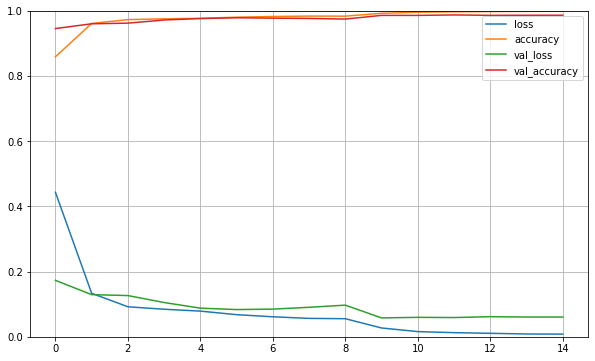

In [ ]:
del history.history['lr']
plot_losses(history)

### *Test (on Target)*

In [47]:
test_loss, test_acc = model.evaluate(x_test_B, y_test_B, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.9199 - accuracy: 0.8398

Test accuracy: 0.8398000001907349


In [ ]:
compute_accuracy_mean_std(x_train=x_train_fakeB, 
                          y_train=y_train_A, 
                          x_val=x_val_fakeB, 
                          y_val=y_val_A, 
                          x_test=x_test_B, 
                          y_test=y_test_B)

*Confusion Matrix*

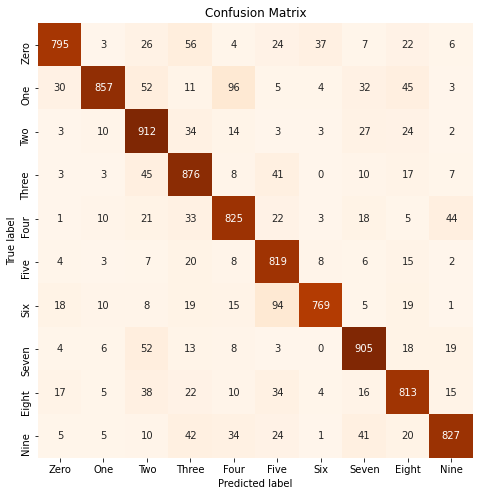

In [48]:
y_pred = np.argmax(model.predict(x_test_B), axis=-1)

conf_matrix = confusion_matrix(y_test_B, y_pred)

plot_conf_matrix(conf_matrix)

*Classification Metrics*

In [49]:
print(classification_report(y_test_B, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Zero       0.90      0.81      0.85       980
         One       0.94      0.76      0.84      1135
         Two       0.78      0.88      0.83      1032
       Three       0.78      0.87      0.82      1010
        Four       0.81      0.84      0.82       982
        Five       0.77      0.92      0.84       892
         Six       0.93      0.80      0.86       958
       Seven       0.85      0.88      0.86      1028
       Eight       0.81      0.83      0.82       974
        Nine       0.89      0.82      0.85      1009

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



### *Features Visualization (t-SNE)*

*t-SNE plot extracted features (Domain A->B vs Domain B)*

Computing t-SNE embedding..


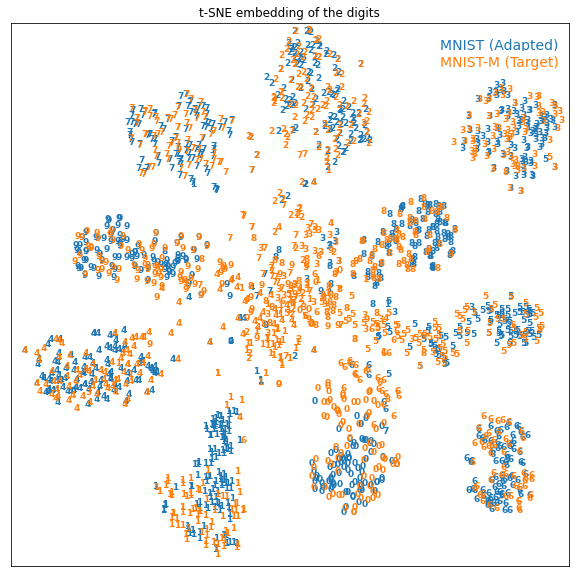

In [50]:
features_extractor = keras.models.Sequential(model.layers[:6])

embenddingsA = features_extractor.predict(x_test_fakeB[:1000])
embenddingsB = features_extractor.predict(x_test_B[:1000])

embenddings = np.concatenate([embenddingsA, embenddingsB])

# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding..")
tsne = manifold.TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(embenddings)

plot_domains_embedding(X_tsne[:1000], y_test_A, 
                       X_tsne[1000:], y_test_B, 
                       "t-SNE embedding of the digits",
                       lab1="MNIST (Adapted)",
                       lab2="MNIST-M (Target)") 